In [1]:
# To extract text from PDFs
!pip install pypdf2

# To automatically detect and install GPU dependencies
!apt-get install -y pciutils
!apt-get install -y lshw

# Ollama on Kaggle hack available at:
# https://stackoverflow.com/questions/78394289/running-ollama-on-kaggle
!curl -fsSL https://ollama.com/install.sh | sh
import subprocess
process = subprocess.Popen("ollama serve", shell=True) # Runs on a different thread
!ollama pull llama3 # large language model
!ollama pull mxbai-embed-large # model to embed chunks
!pip install ollama chromadb # ollama to use python API and cheomadb for vectorDB

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pciutils is already the newest version (1:3.7.0-6).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
lshw is already the newest version (02.19.git.2021.06.19.996aaad9c7-2build1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> NVIDIA GPU installed.
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pul

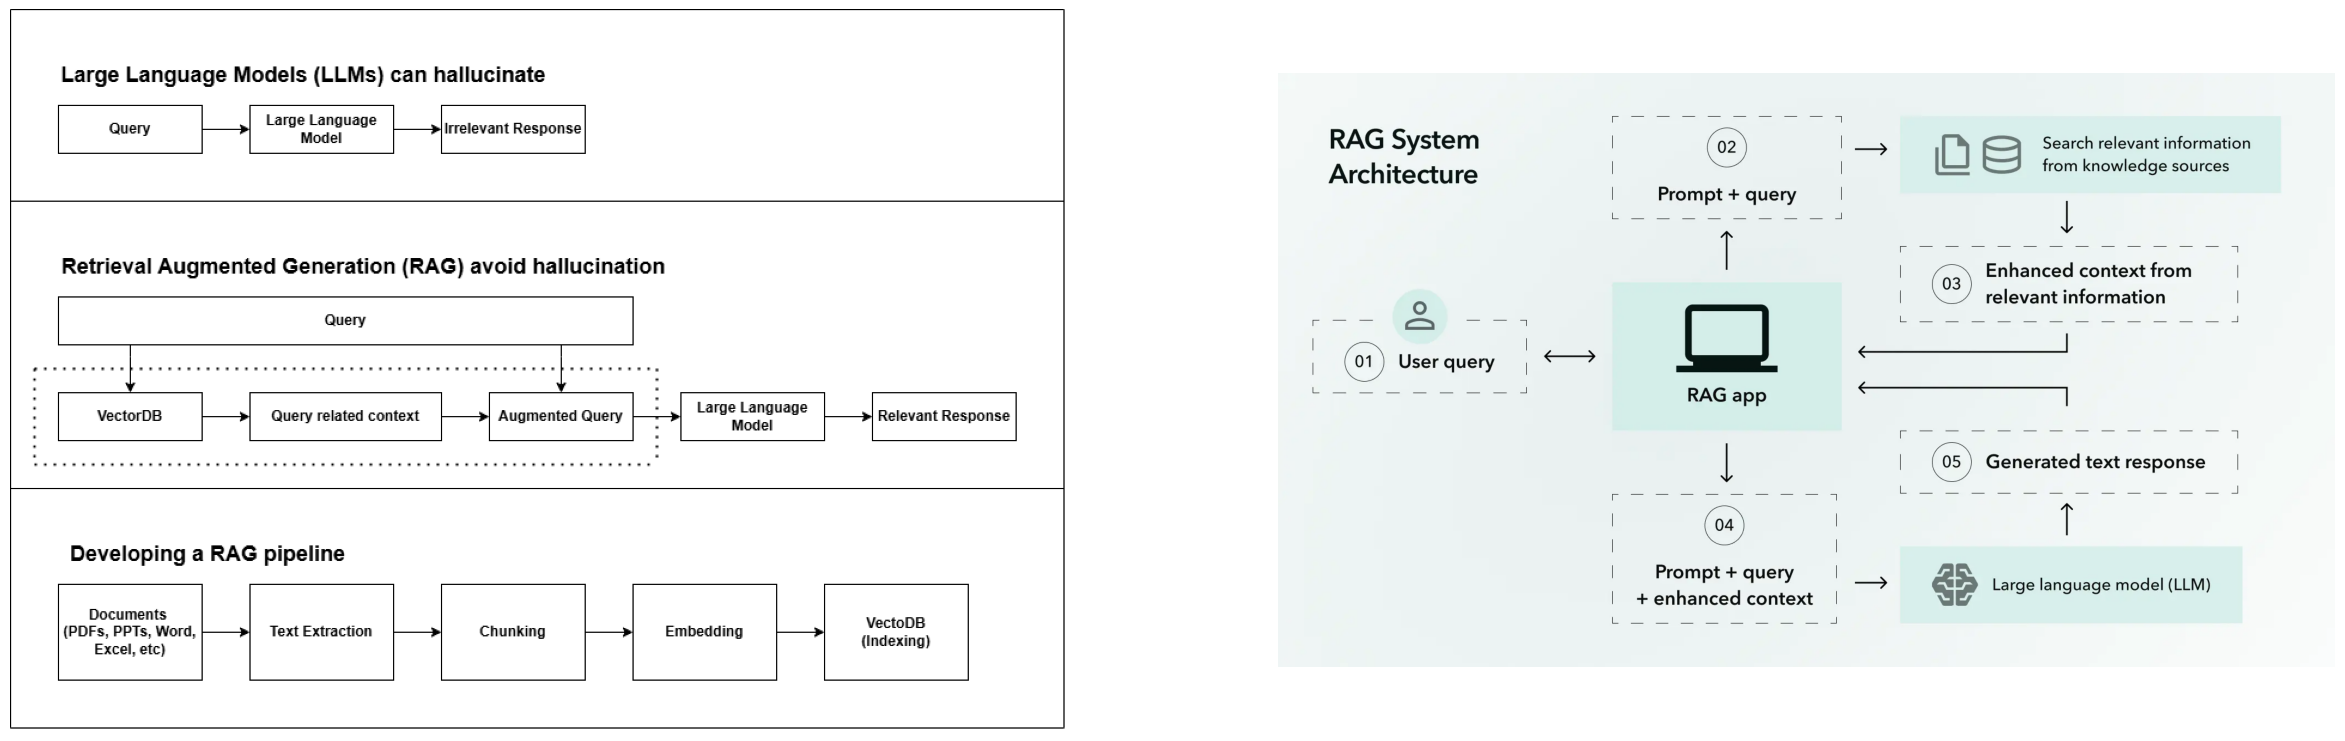

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

png_image_path = "/content/drive/MyDrive/RAG/RAGvsLLM.png"
png_image = Image.open(png_image_path)

webp_image_path = "/content/drive/MyDrive/RAG/RAG.webp"
webp_image = Image.open(webp_image_path)

fig, axes = plt.subplots(1, 2, figsize=(30, 40))

axes[0].imshow(png_image)
axes[0].axis('off')

axes[1].imshow(webp_image)
axes[1].axis('off')

plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import chromadb
import json
import ollama

from glob import glob
from PyPDF2 import PdfReader
from tqdm import tqdm

In [3]:
query = "How do I manage my saved addresses?"

In [4]:
query_model = "llama3"

In [7]:
def get_ollama_response(question, model):
  response = ollama.chat(
      model = model,
      messages =[
          {
              "role":"user",
              "content": question
          }
      ],
      options = {
          "seed":42
      }
  )

  return response["message"]["content"]

In [8]:
response = get_ollama_response(query, query_model)
print(response)

Managing your saved addresses! It's essential to keep them organized and up-to-date. Here are some tips to help you manage your saved addresses effectively:

1. **Create a master list**: Make a note of all the addresses you've saved, whether it's in an email client like Gmail or Outlook, a contact manager like Apple Contacts or Google Contacts, or even a spreadsheet.

2. **Categorize and group**: Group similar addresses together (e.g., work colleagues, family members, friends, vendors). This will make it easier to find specific contacts when needed.

3. **Use labels or tags**: Label each address with relevant information like "Home," "Work," "Favorite Restaurant," or any other categorization that makes sense for you. This way, you can quickly filter and sort addresses based on the label.

4. **Keep it up-to-date**: Regularly update your saved addresses by removing old contacts, updating phone numbers, emails, or physical addresses when they change.

5. **Use a consistent format**: Choo

## Extraction

In [9]:
def read_pdf(file_path):
  reader = PdfReader(file_path)

  text = ""
  for page in reader.pages:
    text += page.extract_text()

  return text

In [24]:
text = read_pdf("/content/drive/MyDrive/RAG/FAQs.pdf")
print(text)

Account Management (1 –15) 
1. How do I create an Amazon account?  
o Click "Sign Up" on the homepage, enter your details, verify your email, and set a 
password.  
2. How do I change my email address?  
o Go to "Account Settings" > "Login & Security" and update your email address.  
3. Can I have multiple accounts?  
o Yes, but each account must have a unique email address.  
4. How do I recover a forgotten password?  
o Click "Forgot Password?" on the login page and follow the instructions to reset it.  
5. How do I close my Amazon account?  
o Contact Customer Support and request account closure.  
6. How do I enable two -factor authentication (2FA)?  
o Go to "Login & Security," enable 2FA, and follow the prompts to set it up.  
7. How do I check my account activity?  
o Access "Login & Security" to view login history and active sessions.  
8. What is a Prime account?  
o Prime offers benefits like faster shipping, streaming services, and exclusive deals for a 
monthly fee.  
9. Ho

## Chunking

In [12]:
def chunk_text(text, max_chars=2000, overlap=200):

  chunks = []
  start = 0

  while start < len(text):
    end = min(start + max_chars, len(text))
    chunks.append(text[start:end])
    start += max_chars - overlap

  return chunks

In [13]:
chunks = chunk_text(text, max_chars=2000, overlap=200)
chunks

['Account Management (1 –15) \n1. How do I create an Amazon account?  \no Click "Sign Up" on the homepage, enter your details, verify your email, and set a \npassword.  \n2. How do I change my email address?  \no Go to "Account Settings" > "Login & Security" and update your email address.  \n3. Can I have multiple accounts?  \no Yes, but each account must have a unique email address.  \n4. How do I recover a forgotten password?  \no Click "Forgot Password?" on the login page and follow the instructions to reset it.  \n5. How do I close my Amazon account?  \no Contact Customer Support and request account closure.  \n6. How do I enable two -factor authentication (2FA)?  \no Go to "Login & Security," enable 2FA, and follow the prompts to set it up.  \n7. How do I check my account activity?  \no Access "Login & Security" to view login history and active sessions.  \n8. What is a Prime account?  \no Prime offers benefits like faster shipping, streaming services, and exclusive deals for a \n

## Embedding

In [14]:
embedding_model = "mxbai-embed-large"

In [18]:
def generate_embedding(chunk, model):
  respose = ollama.embeddings(
      model = model,
      prompt = chunk,
      options = {
          "Seed" : 42
      }
  )
  return respose["embedding"]

In [19]:
chunk = chunks[0]
embedding = generate_embedding(chunk, embedding_model)
print(embedding)

[0.285856157541275, -0.011380329728126526, -0.6473504900932312, 0.33177271485328674, 0.3513453006744385, -0.12764638662338257, -0.09370623528957367, 0.24322447180747986, 1.28146493434906, 0.2230149656534195, -0.1610950231552124, 0.42476314306259155, 0.2027437686920166, -0.019028589129447937, -0.26282212138175964, 0.30328887701034546, -0.42994824051856995, -0.07729443162679672, 0.17008301615715027, -0.7647926807403564, 0.5892722606658936, -0.22975832223892212, -1.1465870141983032, 0.06253013014793396, -0.26394030451774597, 0.046510472893714905, -0.5882096290588379, 0.5145496726036072, 1.1324318647384644, 0.8030213713645935, -1.0179345607757568, 0.36098697781562805, 0.9664139151573181, -0.307639479637146, -0.4811251163482666, 0.12451502680778503, 0.5313089489936829, -0.2659699320793152, -1.3978618383407593, -0.45798906683921814, 0.3118031322956085, -0.8691719770431519, 1.1543067693710327, 0.05143062025308609, -1.143326997756958, 0.213199645280838, -0.21515107154846191, -0.218027815222740

## Indexing with VectorDB

In [20]:
client = chromadb.Client()
collection = client.create_collection(name="docs")

In [ ]:
# Insert record into the collection
# Example document with its embedding
document_id = "doc_1"
document_text = "This is a sample document for testing."
document_embedding = [0.12, 0.45, 0.78, 0.89]  # Example embedding vector

collection.add(
    ids=[document_id],
    embeddings=[document_embedding],
    metadatas=[{"text": document_text}]
)

print(f"Document '{document_id}' inserted successfully.")


In [ ]:
# View record

records = collection.get()
print("Stored records:", records)

In [ ]:
# Delete a specific record from the collection
document_id = "doc_1"

collection.delete(ids=[document_id])
print(f"Document '{document_id}' deleted successfully.")


In [ ]:
# View record
records_after_deletion = collection.get()
print("Records after deletion:", records_after_deletion)


#### Combining everything

In [25]:
# Paths to PDFs
pdf_paths = glob("/content/drive/MyDrive/RAG/*.pdf")
print(pdf_paths)

['/content/drive/MyDrive/RAG/FAQs.pdf', '/content/drive/MyDrive/RAG/how-to-guides.pdf', '/content/drive/MyDrive/RAG/production-information.pdf']


In [26]:
for i, path in tqdm(enumerate(pdf_paths)):

    # Extraction
    text = read_pdf(path)

    # Chunking
    chunks = chunk_text(text, max_chars=2000, overlap=200)

    # Embedding
    for c, chunk in enumerate(chunks):
        embedding = generate_embedding(chunk, embedding_model)

        # Storing
        collection.add(
            ids=[f"{i}{c}"],
            embeddings=[embedding],
            documents=[chunk],
        )

3it [00:04,  1.47s/it]


### Query VectorDB

In [27]:
query_embedding = generate_embedding(query, embedding_model)

k = 3 # For kNN search

# https://stackoverflow.com/questions/76482987/chroma-database-embeddings-none-when-using-get
results = collection.query(
  query_embeddings = [query_embedding],
  n_results = k
)

results

{'ids': [['00', '12', '01']],
 'embeddings': None,
 'documents': [['Account Management (1 –15) \n1. How do I create an Amazon account?  \no Click "Sign Up" on the homepage, enter your details, verify your email, and set a \npassword.  \n2. How do I change my email address?  \no Go to "Account Settings" > "Login & Security" and update your email address.  \n3. Can I have multiple accounts?  \no Yes, but each account must have a unique email address.  \n4. How do I recover a forgotten password?  \no Click "Forgot Password?" on the login page and follow the instructions to reset it.  \n5. How do I close my Amazon account?  \no Contact Customer Support and request account closure.  \n6. How do I enable two -factor authentication (2FA)?  \no Go to "Login & Security," enable 2FA, and follow the prompts to set it up.  \n7. How do I check my account activity?  \no Access "Login & Security" to view login history and active sessions.  \n8. What is a Prime account?  \no Prime offers benefits like

### Prompt Engineering

In [28]:
context = results["documents"][0]

augmented_query = query + "\n\nUse the following context:\n\n"
for i, c in enumerate(context, start=1):
    augmented_query += f"{i}) {c}\n"

print(augmented_query)

How do I manage my saved addresses?

Use the following context:

1) Account Management (1 –15) 
1. How do I create an Amazon account?  
o Click "Sign Up" on the homepage, enter your details, verify your email, and set a 
password.  
2. How do I change my email address?  
o Go to "Account Settings" > "Login & Security" and update your email address.  
3. Can I have multiple accounts?  
o Yes, but each account must have a unique email address.  
4. How do I recover a forgotten password?  
o Click "Forgot Password?" on the login page and follow the instructions to reset it.  
5. How do I close my Amazon account?  
o Contact Customer Support and request account closure.  
6. How do I enable two -factor authentication (2FA)?  
o Go to "Login & Security," enable 2FA, and follow the prompts to set it up.  
7. How do I check my account activity?  
o Access "Login & Security" to view login history and active sessions.  
8. What is a Prime account?  
o Prime offers benefits like faster shipping,

In [29]:
response = get_ollama_response(augmented_query, query_model)
print(response)

According to the context, you can manage your saved addresses by going to "Account Settings" > "Your Addresses". From there, you can:

* Add new addresses
* Update existing addresses
* Delete addresses that are no longer needed
